## Accessing live data

## Installation of access permit cards to yfinance libraries.

In [56]:
pip install iexfinance


In [57]:
pip install mplfinance


In [58]:
pip install mplcursors


In [59]:
pip install plotly

In [60]:
pip install pytz


In [61]:
pip install apscheduler


In [88]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [92]:
pip install joblib


In [89]:
import streamlit as st
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.ticker as ticker
import time
import random
import pytz
from apscheduler.schedulers.blocking import BlockingScheduler
import os
import requests
import yfinance as yf
from requests.exceptions import HTTPError, RequestException
from iexfinance.stocks import Stock
import mplfinance as mpf


## Data display from IEX Cloud.

In [63]:
iex_cloud_token = 'sk_a523cbccbdcf4a8287aa2197c860c131'
symbol = 'GOOG'
response = requests.get(f'https://cloud.iexapis.com/stable/stock/{symbol}/chart/1y?token={iex_cloud_token}')
if response.status_code == 200:

    data = response.json()
    df = pd.DataFrame(data)

    print(df)
else:
    print('Failed to retrieve data from IEX Cloud')



      close     high       low    open   priceDate symbol    volume  \
0    101.36  103.000  100.2800  103.00  2023-03-28   GOOG  24913480   
1    101.90  102.820  101.0300  102.72  2023-03-29   GOOG  26148300   
2    101.32  101.610  100.2900  101.44  2023-03-30   GOOG  25009829   
3    104.00  104.190  101.4400  101.71  2023-03-31   GOOG  28107953   
4    104.91  104.950  102.3800  102.67  2023-04-03   GOOG  20719861   
..      ...      ...       ...     ...         ...    ...       ...   
247  148.74  151.305  148.0101  150.32  2024-03-21   GOOG  19843915   
248  151.77  152.560  150.0900  150.24  2024-03-22   GOOG  19252925   
249  151.15  151.456  148.8000  150.95  2024-03-25   GOOG  15114728   
250  151.70  153.200  151.0300  151.24  2024-03-26   GOOG  19312694   
251  151.94  152.690  150.1400  152.05  2024-03-27   GOOG   7297251   

                    id   key subkey  ...      uLow   uVolume   fOpen  fClose  \
0    HISTORICAL_PRICES  GOOG         ...  100.2800  24913480  103.0

# Data processing and splitting.

In [64]:
iex_cloud_token = 'sk_a523cbccbdcf4a8287aa2197c860c131'
symbol = 'GOOG'

stock = Stock(symbol, token=iex_cloud_token)
live_data = stock.get_quote()
live_price = live_data['latestPrice']
data = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])

live_data_entry = {'Date': live_data['latestUpdate'], 'Open': live_price, 'High': live_price, 'Low': live_price, 'Close': live_price, 'Adj Close': live_price, 'Volume': 0}
data = data.append(pd.DataFrame([live_data_entry]), ignore_index=True)

target_column = 'Close'
data = data[[target_column]].copy()

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences for the CNN model
sequence_length = 10
sequences = []
targets = []

for i in range(len(data_scaled) - sequence_length):
    seq = data_scaled[i:i + sequence_length]
    label = data_scaled[i + sequence_length:i + sequence_length + 1]
    sequences.append(seq)
    targets.append(label)

np.random.seed(42)
X = np.random.rand(100, 10)
y = np.random.randint(0, 2, 100)
test_size = 0.2
# data spilliting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("Training set - Features:", X_train.shape, "Labels:", y_train.shape)
print("Testing set - Features:", X_test.shape, "Labels:", y_test.shape)

Training set - Features: (80, 10) Labels: (80,)
Testing set - Features: (20, 10) Labels: (20,)


<ipython-input-64-cf055b80d852>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame([live_data_entry]), ignore_index=True)


### VAR model

In [73]:
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
iex_cloud_token = 'sk_a523cbccbdcf4a8287aa2197c860c131'
def fetch_stock_data(symbol, start_date, end_date):
    try:
        data = yf.download(symbol, start=start_date, end=end_date)
        return data
    except Exception as e:
        print(f"Error fetching data from Yahoo Finance: {e}")
        return None
symbol = 'GOOG'
start_date = '2022-01-01'
end_date = '2022-12-31'
stock_data = fetch_stock_data(symbol, start_date, end_date)
if stock_data is not None:

    data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].copy().dropna()
    train_size = int(len(data) * 0.8)
    train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]
    model = VAR(train_data)
    model_fit = model.fit()
    forecast = model_fit.forecast(model_fit.endog, steps=len(test_data))
    mse = np.mean((forecast[:, 3] - test_data['Close'].values.flatten())**2)
    print(f'Mean Squared Error on Test Data: {mse}')
    df_results = pd.DataFrame({'Actual': test_data['Close'].values.flatten(), 'Predicted': forecast[:, 3]})
    print(df_results.head())

else:
    print("Error fetching data. Please check your input parameters and try again.")


[*********************100%%**********************]  1 of 1 completed

Mean Squared Error on Test Data: 164.9491388481179
       Actual   Predicted
0  100.290001  101.544114
1  100.529999  101.768830
2  101.480003  101.979674
3  102.970001  102.199769
4  104.930000  102.419710



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## LSTM model.

In [74]:
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense

iex_cloud_token = 'sk_a523cbccbdcf4a8287aa2197c860c131'
symbol = 'GOOG'


data = yf.download(symbol, start='2022-01-01', end='2022-12-31')
target_column = 'Close'
data = data[[target_column]].copy()
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
sequences = []
targets = []

for i in range(len(data_scaled) - sequence_length):
    seq = data_scaled[i:i + sequence_length]
    label = data_scaled[i + sequence_length:i + sequence_length + 1]
    sequences.append(seq)
    targets.append(label)

X = np.array(sequences)
y = np.array(targets)

# data split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Train
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')
y_pred = model.predict(X_test)

y_pred_original_scale = scaler.inverse_transform(np.reshape(y_pred, (-1, 1)))

print("Actual vs. Predicted Prices:")
print(pd.DataFrame({'Actual': scaler.inverse_transform(np.reshape(y_test, (-1, 1))).flatten(),
                    'Predicted': y_pred_original_scale.flatten()}).head())

[*********************100%%**********************]  1 of 1 completed

Epoch 1/50


6/6 [==============================] - 1s 58ms/step - loss: 0.1585 - val_loss: 0.1147
Epoch 2/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0908 - val_loss: 0.0551
Epoch 3/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0384 - val_loss: 0.0127
Epoch 4/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0097
Epoch 5/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0144 - val_loss: 0.0101
Epoch 6/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0098 - val_loss: 0.0052
Epoch 7/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 8/50
6/6 [==============================] - 0s 13ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 9/50
6/6 [==============================] - 0s 11ms/step - loss: 0.0063 - val_loss: 0.0042
Epoch 10/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 11/50
6/6 [=======================

## daily prediction

In [75]:
from pytz import timezone
from datetime import datetime, timedelta
kenya_timezone = timezone('Africa/Nairobi')
current_time_kenya = datetime.now(kenya_timezone)
future_date = current_time_kenya + timedelta(days=1)
future_data = pd.DataFrame({'Date': [future_date]})
future_data['Close'] = np.nan
input_data = data.tail(sequence_length).values.reshape(1, sequence_length, 1)
predicted_price = model.predict(input_data)

# Store the predicted price in the DataFramefuture_data.loc[0, 'Close'] = predicted_price[0, 0]

print("Predicted price for the next day:")
print(future_data[['Date', 'Close']])

1/1 [==============================] - 0s 22ms/step
Predicted price for the next day:
                              Date  Close
0 2024-03-29 14:25:07.424526+03:00    NaN


### week prediction

In [77]:
from pytz import timezone
from datetime import datetime, timedelta
kenya_timezone = timezone('Africa/Nairobi')
current_time_kenya = datetime.now(kenya_timezone)
future_dates = pd.date_range(current_time_kenya, current_time_kenya + timedelta(days=7), freq='D')
future_data = pd.DataFrame({'Date': future_dates})
last_week_data = data.tail(sequence_length).values
future_data['Close'] = np.nan
for i in range(len(future_data)):
    input_data = last_week_data.reshape(1, sequence_length, 1)
    predicted_price = model.predict(input_data)
    future_data.loc[i, 'Close'] = predicted_price[0, 0]
    last_week_data = np.append(last_week_data[1:], predicted_price, axis=0)

print("Predicted prices for the next week:")
print(future_data[['Date', 'Close']])




1/1 [==============================] - 0s 35ms/step
Predicted prices for the next week:
                              Date       Close
0 2024-03-28 14:25:41.838818+03:00 -508.278595
1 2024-03-29 14:25:41.838818+03:00 -599.184082
2 2024-03-30 14:25:41.838818+03:00 -650.913147
3 2024-03-31 14:25:41.838818+03:00 -564.500671
4 2024-04-01 14:25:41.838818+03:00 -651.911316
5 2024-04-02 14:25:41.838818+03:00 -591.464233
6 2024-04-03 14:25:41.838818+03:00 -474.269653
7 2024-04-04 14:25:41.838818+03:00   84.502251


## LSTM model accuracy test score.

In [78]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = model.predict(X_test)
y_pred_original_scale = scaler.inverse_transform(np.reshape(y_pred, (-1, 1)))
y_test_original_scale = scaler.inverse_transform(np.reshape(y_test, (-1, 1)))
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
print(f'Mean Squared Error (MSE): {mse}')
r2 = r2_score(y_test_original_scale, y_pred_original_scale)
print(f'Score: {r2}')


2/2 [==============================] - 0s 9ms/step
Mean Squared Error (MSE): 14.74890581248043
Score: 0.934768538812432


## VAR model accuracy score.

In [79]:
import numpy as np
from sklearn.metrics import mean_squared_error
def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))
test_actual = test_data['Close'].values.flatten()
test_predicted = forecast[:, 3]
test_rmse = rmse(test_actual, test_predicted)

print(f'Root Mean Squared Error on Test Data: {test_rmse}')


Root Mean Squared Error on Test Data: 12.843252658424108


###Google Stock Visualization

[*********************100%%**********************]  1 of 1 completed


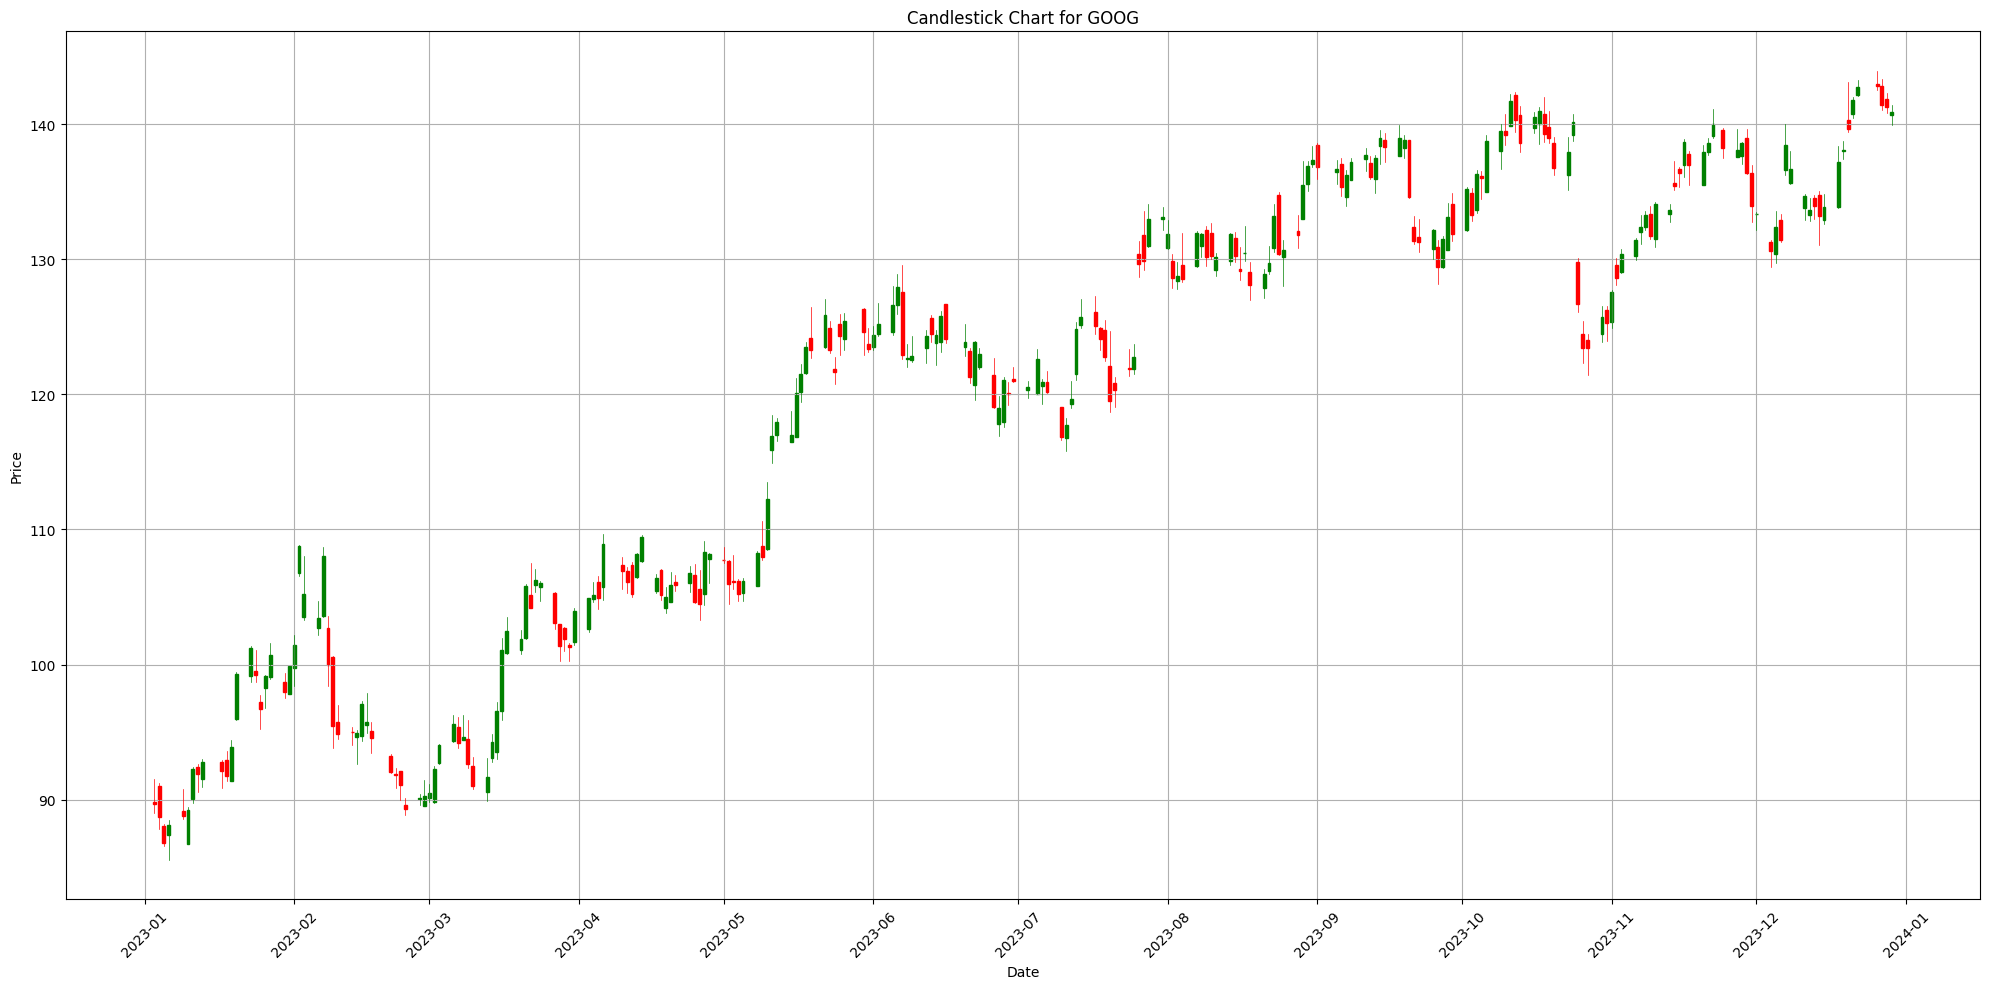

In [84]:
import matplotlib.dates as mdates

def visualize_candlestick_chart_with_profit(selected_stock):

    data_stock = yf.download(selected_stock, start='2023-01-01', end='2023-12-31')

    data_stock.reset_index(inplace=True)
    data_stock['Date'] = data_stock['Date'].map(mdates.date2num)

    # candlestick chart plot
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

    candlestick_ohlc(ax, data_stock[['Date', 'Open', 'High', 'Low', 'Close']].values, width=0.6, colorup='g', colordown='r')
    plt.title(f'Candlestick Chart for {selected_stock}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    def zoom(event):
        xdata = event.xdata
        if xdata is None:
            return
        xmin, xmax = ax.get_xlim()
        xdist = (xmax - xmin)
        if event.key == 'a':
            ax.set_xlim(xdata - xdist / 4, xdata + xdist / 4)
        elif event.key == 'z':
            ax.set_xlim(xmin - xdist / 4, xmax + xdist / 4)
        plt.draw()

    fig.canvas.mpl_connect('key_press_event', zoom)

    plt.show()

    profit_percentage = random.uniform(1.0, 25.0)

selected_stock = 'GOOG'
visualize_candlestick_chart_with_profit(selected_stock)

In [85]:
import pickle

In [86]:
with open('classifier.pkl','wb') as file:
  pickle.dump(model, file)

In [96]:
import joblib
model = joblip.load('Google Stock Price Prediction Machine Learning Model')
st.title('GGole Stock Predictor')


NameError: name 'joblip' is not defined